Processing /dtu/datasets1/02516/potholes/images/potholes0.png...
Found 1160 proposals.


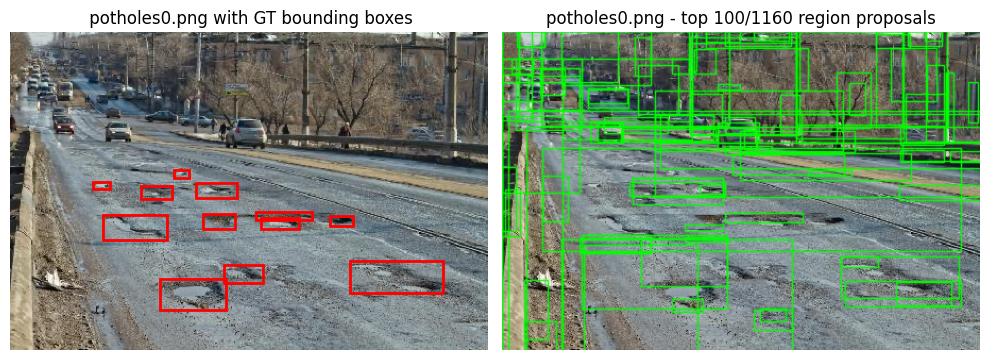

In [10]:
from pathlib import Path

import cv2
import glob
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import xmltodict
from matplotlib.patches import Rectangle
from tqdm import tqdm

# Load the image
image_path = "/dtu/datasets1/02516/potholes/images/potholes0.png"
img = mpimg.imread(image_path)

# Load and parse the XML file
xml_path = "/dtu/datasets1/02516/potholes/annotations/potholes0.xml"

with Path(xml_path).open() as file:
    file_data = file.read() # read file contents

    # parse data using package
    dict_data = xmltodict.parse(file_data)

# Extract bounding box coordinates
list_with_all_boxes = []
for obj in dict_data["annotation"]["object"]:
        ymin = int(obj["bndbox"]["ymin"])
        xmin = int(obj["bndbox"]["xmin"])
        ymax = int(obj["bndbox"]["ymax"])
        xmax = int(obj["bndbox"]["xmax"])

        list_with_single_boxes = [xmin, ymin, xmax, ymax]
        list_with_all_boxes.append(list_with_single_boxes)

# Plot the image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img)

# Add bounding boxes to the image
for box in list_with_all_boxes:
    xmin, ymin, xmax, ymax = box
    width = xmax - xmin
    height = ymax - ymin
    rect = Rectangle((xmin, ymin), width, height, edgecolor="red", facecolor="none", linewidth=2)
    ax[0].add_patch(rect)

ax[0].axis("off")
ax[0].set_title(f" {Path(image_path).name} with GT bounding boxes")


def run_selective_search(image, method='fast'):
    # Create Selective Search Segmentation Object using default parameters
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    
    # Set the image on which we will run segmentation
    ss.setBaseImage(image)
    
    # Switch to fast but low recall Selective Search method
    if method == 'fast':
        ss.switchToSelectiveSearchFast()
    # Switch to high recall but slow Selective Search method
    elif method == 'quality':
        ss.switchToSelectiveSearchQuality()
        
    # Run selective search segmentation on input image
    rects = ss.process()
    return rects

# Run Selective Search
img = cv2.imread(image_path)
if img is None:
    raise FileNotFoundError(f"Image not found at path: {image_path}")
rects = run_selective_search(img, method='fast')

print(f"Processing {image_path}...")
print(f"Found {len(rects)} proposals.")

imOut = img.copy()
# Draw top 100 proposals
for j, (x, y, w, h) in enumerate(rects):
    if j < 100:
        cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)

ax[1].imshow(cv2.cvtColor(imOut, cv2.COLOR_BGR2RGB))
ax[1].set_title(f"{os.path.basename(image_path)} - top 100/{len(rects)} region proposals")
ax[1].axis('off')
plt.tight_layout()
plt.savefig("figures/selective_search_example.png")
plt.show()

In [11]:
# Path to images
image_dir = "/dtu/datasets1/02516/potholes/images/"
image_paths = sorted(glob.glob(os.path.join(image_dir, "*.png")))

print(f"Found {len(image_paths)} images.")

# Dictionary to store proposals for all images
all_proposals = {}

# Loop through all images
for i, img_path in tqdm(enumerate(image_paths), total=len(image_paths), desc="Processing images"):
    img = cv2.imread(img_path)
    if img is None:
        continue

    # Run Selective Search
    rects = run_selective_search(img, method='fast')

    # Store proposals
    rects_original = []
    for (x, y, w, h) in rects:
        rects_original.append([int(x), int(y), int(w), int(h)])
        
    all_proposals[os.path.basename(img_path)] = rects_original

print(f"Processed {len(all_proposals)} images.")

Found 665 images.


Processing images: 100%|██████████| 665/665 [10:58<00:00,  1.01it/s]

Processed 665 images.


Loaded annotations for 665 images.
Training set: 532 images
Test set: 133 images
Recall and MABO at different number of proposals:
Top 50: Recall=0.3896, MABO=0.4116
Top 100: Recall=0.5736, MABO=0.5224
Top 500: Recall=0.8735, MABO=0.6948
Top 1000: Recall=0.9014, MABO=0.7276
Top 1500: Recall=0.9034, MABO=0.7386
Top 2000: Recall=0.9034, MABO=0.7399


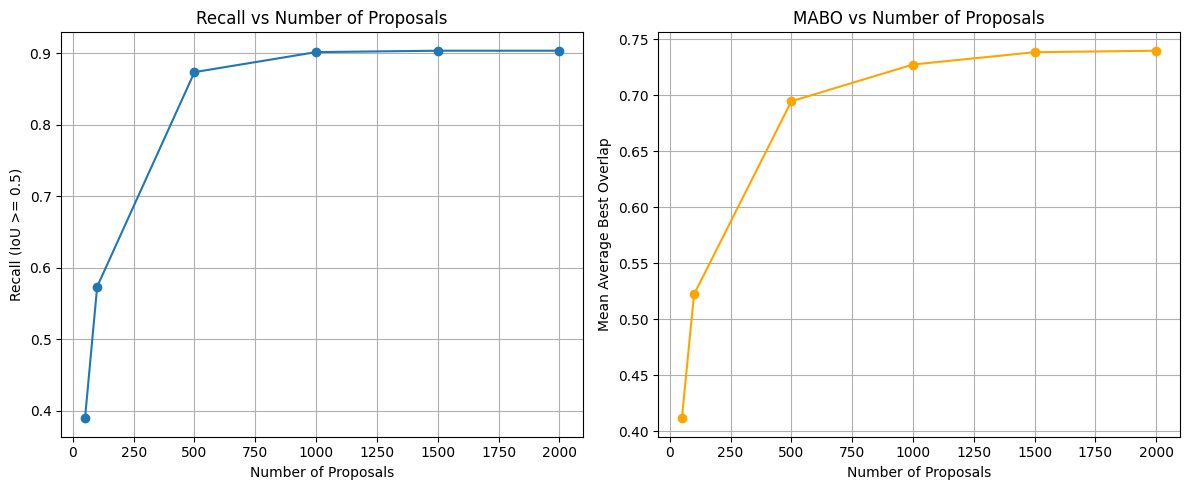

In [12]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. Load Ground Truth Annotations
annotation_dir = "/dtu/datasets1/02516/potholes/annotations/"
all_annotations = {}

# Ensure we have proposals loaded (from previous cell)
if 'all_proposals' not in locals():
    print("Error: all_proposals not found. Please run the previous cell first.")
else:
    for img_name in all_proposals.keys():
        xml_name = os.path.splitext(img_name)[0] + ".xml"
        xml_path = os.path.join(annotation_dir, xml_name)
        
        if os.path.exists(xml_path):
            with open(xml_path) as file:
                file_data = file.read()
                dict_data = xmltodict.parse(file_data)
                
                boxes = []
                if "object" in dict_data["annotation"]:
                    objects = dict_data["annotation"]["object"]
                    if not isinstance(objects, list):
                        objects = [objects]
                    
                    for obj in objects:
                        ymin = int(obj["bndbox"]["ymin"])
                        xmin = int(obj["bndbox"]["xmin"])
                        ymax = int(obj["bndbox"]["ymax"])
                        xmax = int(obj["bndbox"]["xmax"])
                        # Store as [xmin, ymin, xmax, ymax]
                        boxes.append([xmin, ymin, xmax, ymax])
                all_annotations[img_name] = boxes

    print(f"Loaded annotations for {len(all_annotations)} images.")

    # 2. Train/Test Split
    image_names = list(all_annotations.keys())
    train_images, test_images = train_test_split(image_names, test_size=0.2, random_state=42)

    print(f"Training set: {len(train_images)} images")
    print(f"Test set: {len(test_images)} images")

    # 3. Evaluate Proposals on Training Set
    def compute_iou(boxA, boxB):
        # boxA, boxB: [xmin, ymin, xmax, ymax]
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])
        
        interArea = max(0, xB - xA) * max(0, yB - yA)
        
        boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
        boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
        
        iou = interArea / float(boxAArea + boxBArea - interArea)
        return iou

    def evaluate_recall(image_list, proposals_dict, annotations_dict, k_values=[100, 500, 1000, 2000]):
        recalls = {k: [] for k in k_values}
        
        for img_name in image_list:
            gt_boxes = annotations_dict[img_name]
            if len(gt_boxes) == 0:
                continue
                
            # Proposals are [x, y, w, h]
            proposals = proposals_dict[img_name]
            
            # Convert to [xmin, ymin, xmax, ymax]
            proposals_xyxy = [[p[0], p[1], p[0]+p[2], p[1]+p[3]] for p in proposals]
                
            for k in k_values:
                current_proposals = proposals_xyxy[:k]
                found_gt = 0
                for gt in gt_boxes:
                    # Check if this GT is covered by any proposal with IoU >= 0.5
                    covered = False
                    for prop in current_proposals:
                        if compute_iou(gt, prop) >= 0.5:
                            covered = True
                            break
                    if covered:
                        found_gt += 1
                
                recall = found_gt / len(gt_boxes)
                recalls[k].append(recall)
                
        avg_recalls = {k: np.mean(v) for k, v in recalls.items()}
        return avg_recalls

    def evaluate_mabo(image_list, proposals_dict, annotations_dict, k_values=[100, 500, 1000, 2000]):
        mabos = {k: [] for k in k_values}
        
        for img_name in image_list:
            gt_boxes = annotations_dict[img_name]
            if len(gt_boxes) == 0:
                continue
                
            # Proposals are [x, y, w, h]
            proposals = proposals_dict[img_name]
            
            # Convert to [xmin, ymin, xmax, ymax]
            proposals_xyxy = [[p[0], p[1], p[0]+p[2], p[1]+p[3]] for p in proposals]
                
            for k in k_values:
                current_proposals = proposals_xyxy[:k]
                if not current_proposals:
                    mabos[k].append(0.0)
                    continue

                best_overlaps = []
                for gt in gt_boxes:
                    max_iou = 0.0
                    for prop in current_proposals:
                        iou = compute_iou(gt, prop)
                        if iou > max_iou:
                            max_iou = iou
                    best_overlaps.append(max_iou)
                
                # Average Best Overlap for this image
                abo = np.mean(best_overlaps)
                mabos[k].append(abo)
                
        avg_mabos = {k: np.mean(v) for k, v in mabos.items()}
        return avg_mabos

    k_values = [50, 100, 500, 1000, 1500, 2000]
    recall_results = evaluate_recall(train_images, all_proposals, all_annotations, k_values)
    mabo_results = evaluate_mabo(train_images, all_proposals, all_annotations, k_values)

    print("Recall and MABO at different number of proposals:")
    for k in k_values:
        print(f"Top {k}: Recall={recall_results[k]:.4f}, MABO={mabo_results[k]:.4f}")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(k_values, [recall_results[k] for k in k_values], marker='o')
    plt.title("Recall vs Number of Proposals")
    plt.xlabel("Number of Proposals")
    plt.ylabel("Recall (IoU >= 0.5)")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(k_values, [mabo_results[k] for k in k_values], marker='o', color='orange')
    plt.title("MABO vs Number of Proposals")
    plt.xlabel("Number of Proposals")
    plt.ylabel("Mean Average Best Overlap")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

Selecting top 1000 proposals for training data generation.
Generated 356700 training samples.
Positive samples: 10444
Negative samples: 346256
Generated 356700 training samples.
Positive samples: 10444
Negative samples: 346256
Saved training proposals to train_proposals.pkl
Visualizing some positive and negative samples...
Saved training proposals to train_proposals.pkl
Visualizing some positive and negative samples...


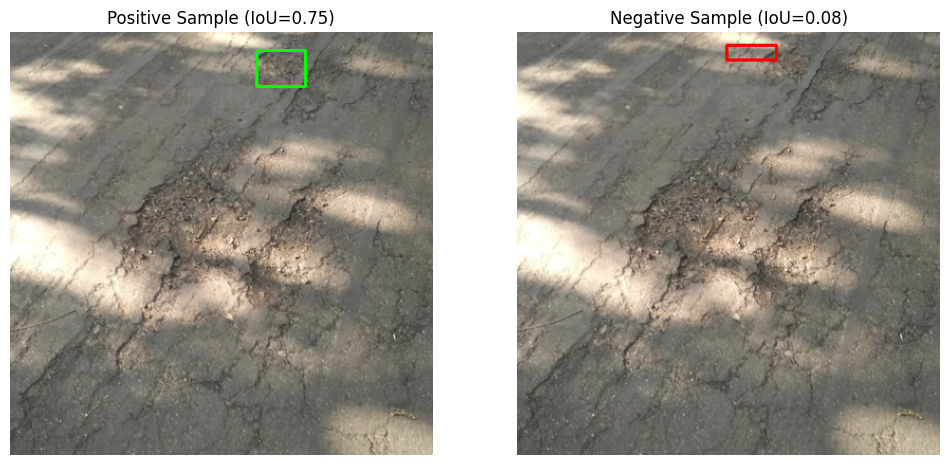

In [ ]:
# 4. Prepare Proposals for Training
import pickle

# Based on the plot, we can choose a number of proposals. 
selected_k = 1000
print(f"Selecting top {selected_k} proposals for training data generation.")

train_proposals_data = []

for img_name in train_images:
    gt_boxes = all_annotations[img_name]
    proposals = all_proposals[img_name][:selected_k]
    
    for p in proposals:
        # p is [x, y, w, h]
        p_xyxy = [p[0], p[1], p[0]+p[2], p[1]+p[3]]
        
        best_iou = 0.0
        for gt in gt_boxes:
            iou = compute_iou(gt, p_xyxy)
            if iou > best_iou:
                best_iou = iou
        
        # Assign label: 1 if IoU >= 0.5, 0 otherwise
        label = 1 if best_iou >= 0.5 else 0
        
        train_proposals_data.append({
            'image': img_name,
            'proposal': p, # [x, y, w, h]
            'label': label,
            'iou': best_iou
        })

print(f"Generated {len(train_proposals_data)} training samples.")
pos_count = sum(1 for x in train_proposals_data if x['label'] == 1)
neg_count = len(train_proposals_data) - pos_count
print(f"Positive samples: {pos_count}")
print(f"Negative samples: {neg_count}")

# Save the prepared data
output_file = "train_proposals.pkl"
with open(output_file, "wb") as f:
    pickle.dump(train_proposals_data, f)
print(f"Saved training proposals to {output_file}")

# Visualize some samples
print("Visualizing some positive and negative samples...")
pos_samples = [x for x in train_proposals_data if x['label'] == 1]
neg_samples = [x for x in train_proposals_data if x['label'] == 0]

plt.figure(figsize=(12, 6))

# Positive sample
if pos_samples:
    sample = pos_samples[0]
    img_path = os.path.join(image_dir, sample['image'])
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        x, y, w, h = sample['proposal']
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title(f"Positive Sample (IoU={sample['iou']:.2f})")
        plt.axis('off')

# Negative sample
if neg_samples:
    sample = neg_samples[0]
    img_path = os.path.join(image_dir, sample['image'])
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        x, y, w, h = sample['proposal']
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        
        plt.subplot(1, 2, 2)
        plt.imshow(img)
        plt.title(f"Negative Sample (IoU={sample['iou']:.2f})")
        plt.axis('off')

plt.show()